# Chapter 2 Exercises:

## Exercise 2.1

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.optimize import fsolve, broyden1
import pandas as pd
from functools import reduce
import pickle
import scipy.stats 

In [161]:
##returns from the Wilshire 5000
headers = ['date', 'returns']
returns = pd.read_csv('WILL5000INDFC.csv', header=None, names=headers, skiprows=1)
returns['date'] = pd.to_datetime(returns['date'])
returns.set_index('date', inplace=True)
returns['returns'] = pd.to_numeric(returns['returns'], errors='coerce')

##personal consumption expenditure
pce = pd.read_csv('PCECC96.csv')
pce.columns = ['date', 'pce']
pce.set_index('date', inplace=True)
pce['pce'] = pd.to_numeric(pce['pce'], errors='coerce')

##GDP deflator for inflation
deflator = pd.read_csv('GDPDEF.csv')
deflator.columns = ['date', 'deflator']
deflator.set_index('date', inplace=True)
deflator['deflator'] = pd.to_numeric(deflator['deflator'], errors='coerce')

# ##treasury bonds (risk free rate)
# headers = ['date', 'treas']
# treas = pd.read_csv('TB3MS.csv', header=None, names=headers, skiprows=1)
# treas['date'] = pd.to_datetime(treas['date'])
# treas.set_index('date', inplace=True)
# treas['treas'] = pd.to_numeric(treas['treas'], errors='coerce')

headers = ['date', 'treas']
treas = pd.read_csv('TB3MS.csv', header=None, names=headers, skiprows=1)
treas['date'] = pd.to_datetime(treas['date'])
treas.set_index('date', inplace=True)
treas['treas'] = pd.to_numeric(treas['treas'], errors='coerce')

treas = treas.resample('D').asfreq()
treas = treas.fillna(method='ffill')
treas = treas.resample('Q').asfreq()
treas.index = treas.index + pd.DateOffset(1)

In [162]:
##treasury bonds and wilshire are not quarterly. let's fix that
returns = returns.resample('D').asfreq()
returns = returns.fillna(method='ffill')
returns = returns.resample('Q').asfreq()

# treas = treas.resample('D').asfreq()
# treas = treas.fillna(method='ffill')
# treas = treas.resample('Q').asfreq()

returns.index = returns.index + pd.DateOffset(1)
# treas.index = treas.index + pd.DateOffset(1)

In [163]:
## we need 1 dataframe

frim_fram = [returns, deflator, pce, treas]
df = reduce(lambda fram_1, fram_2: fram_1.merge(fram_2, "outer", left_index=True, \
                                                right_index=True), frim_fram)

df.dropna(axis = 0)
df['returns_real'] = df['returns']/(df['deflator']/100)
df['returns_timeshift'] = df['returns_real']/df['returns_real'].shift(1)
# df['treas_real'] = df['treas']/100 + 1 
df['treas'] = df['treas']/100 + 1
df.dropna(axis=0, inplace=True)
print(df.head())


            returns  deflator        pce   treas  returns_real  \
date                                                             
2015-01-01    90.82   104.090  11792.119  1.0003     87.251417   
2015-04-01    92.43   104.675  11885.980  1.0003     88.301887   
2015-07-01    92.43   105.048  11976.589  1.0002     87.988348   
2015-10-01    85.57   105.049  12030.223  1.0002     81.457225   
2016-01-01    90.61   104.941  12124.214  1.0023     86.343755   

            returns_timeshift  
date                           
2015-01-01           1.049183  
2015-04-01           1.012040  
2015-07-01           0.996449  
2015-10-01           0.925773  
2016-01-01           1.059989  


In [164]:
def utility(c, gamma):
    u = (c**(1-gamma))/(1-gamma)
    return u
def u_prime(c, gamma):
    u_prime = c**(-gamma)
    return u_prime
def sdf(u_c_t_next, u_c_t, beta):
    disc_factor = beta*(u_c_t_next/u_c_t)
    return disc_factor

In [165]:
beta = .99
risk_free = .4

params = (df, beta)
def sdf_eqn(gamma, *params):
    df, beta = params
    
    pce = df.pce.values
    
    u_c_t = u_prime(pce, gamma)

    u_c_t_next = u_c_t[1:]

    m = sdf(u_c_t_next, u_c_t[:-1], beta)
    r = df.returns_timeshift.values
    r = r[1:]

    covar = np.cov(m, r)[0, 1]

    E_r = np.mean(r)
    E_m = np.mean(m)

    return 1 - covar - E_m*E_r 
sdf_func = lambda gamma: sdf_eqn(gamma, *params)


In [166]:
gamma = broyden1(sdf_func, .01)

In [167]:
print(gamma)

1.488187070908653


## Exercise 2.2

We can observe in the literature that the value of gamma is usually around 1.39, so our computed value of 1.488 seems quite reasonable.

## Exercise 2.3

In [171]:
import scipy.optimize as opt
def risk_free_eqn(gamma, *params):
    df, beta = params
    
    pce = df.pce.values
    
    u_c_t = u_prime(pce, gamma)

    u_c_t_next = u_c_t[1:]

    m = sdf(u_c_t_next, u_c_t[:-1], beta)
    E_m = np.mean(m)
    risk = df['treas'][1:]
    error = risk - 1./E_m
    
    
    return np.sum(error**2)
risk_free_func = lambda gamma: risk_free_eqn(gamma, *params)


In [172]:
gamma3 = opt.minimize(risk_free_func, .1, method="Nelder-Mead")
print(gamma3)

 final_simplex: (array([[-0.08046875],
       [-0.08039062]]), array([0.0011786, 0.0011786]))
           fun: 0.0011786023529558412
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 15
        status: 0
       success: True
             x: array([-0.08046875])


This gamma is close to zero, significantly lower than before.

## Exercise 2.4

In [216]:
def GMM_est(x, df):
    gamma, beta = x
    errors = np.zeros(2)

    pce = df.pce.values
    
    u_c_t = u_prime(pce, gamma)

    u_c_t_next = u_c_t[1:]

    m = sdf(u_c_t_next, u_c_t[:-1], beta)
    E_m = np.mean(m)
    
    risk = df['treas'][1:]
    
    errors[0] =np.sum((risk - 1./E_m)**2)
    
    r = df.returns_timeshift.values
    r = r[1:]

    covar = np.cov(m, r)[0, 1]

    E_r = np.mean(r)
    errors[1] = 1 - covar - E_m*E_r 
    Weight_mat = np.eye(2)
    final_error = errors.T @ Weight_mat @ errors
    return final_error


gmm_func = lambda x: GMM_est(x, df)


In [217]:
param_vec = opt.minimize(gmm_func, np.array([.22,.66]), method='L-BFGS-B')


0.66
0.66
0.6600000100000001
1.6599898812061293
1.6599898812061293
1.6599898912061293
1.5818215491114405
1.5818215491114405
1.5818215591114404
1.0263895164937846
1.0263895164937846
1.0263895264937846
1.0234098803752738
1.0234098803752738
1.0234098903752737
1.0006532676341229
1.0006532676341229
1.0006532776341228
0.989009137092935
0.989009137092935
0.9890091470929351
0.9820485136453806
0.9820485136453806
0.9820485236453806
0.9823979491050615
0.9823979491050615
0.9823979591050616
0.9823701459843501
0.9823701459843501
0.9823701559843502


In [215]:
param_vec

      fun: 9.107840086058392e-06
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.22281403e-07,  3.60245992e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 9
   status: 0
  success: True
        x: array([0.2200441 , 0.98237015])

In [245]:
def plot_results(gmm_func, N):
    
    gammas = np.linspace(-1, 5, N)
    betas = np.linspace(.9, .999, N)
    
    GMM_ests = np.zeros((N,N))
    icount = 0
    jcount = 0
    for gamma in gammas:
        jcount = 0
        for beta in betas:
            x= [gamma, beta]
            GMM_ests[icount, jcount] = gmm_func(x)
            jcount +=1
        icount +=1
    for i in range(N):
        plt.plot(gammas, GMM_ests[:,i], label="beta = {}".format(betas[i]))
        plt.title("Objective Function")
        plt.legend()
        plt.xlabel("Gamma")
    plt.show()

0.9
0.92475
0.9495
0.9742500000000001
0.999
0.9
0.92475
0.9495
0.9742500000000001
0.999
0.9
0.92475
0.9495
0.9742500000000001
0.999
0.9
0.92475
0.9495
0.9742500000000001
0.999
0.9
0.92475
0.9495
0.9742500000000001
0.999


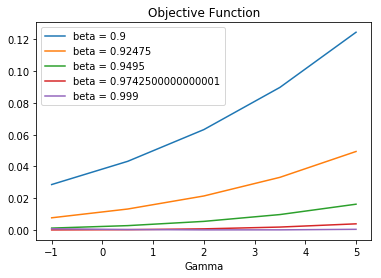

In [246]:
plot_results(gmm_func, 5)

# Chapter 3 Exercises:

## Exercise 1:

In [381]:
class Orderbook:
    
    
    
    def __init__(self, data):
        
        
        self.timestamp = data[0]
        self.orders = data[1]
        
        df = pd.DataFrame.from_dict(self.orders, orient='index')
        df.columns = ['Quantity', 'B/S', 'drop1', 'drop2']
        df = df.drop(['drop1','drop2'],axis=1)
        
        
        self.demand_curve = df[df['B/S'] == 'B'].sort_index(ascending=False)
        self.supply_curve = df[df['B/S'] == 'S'].sort_index()
        self.demand_curve['Quantity_D'] = -self.demand_curve['Quantity'].cumsum()
        self.supply_curve['Quantity_S'] = self.supply_curve['Quantity'].cumsum()
        
        orders = pd.concat([self.demand_curve, self.supply_curve], sort=True)
        orders = orders.fillna(0)
        orders['Net_Quantity'] = orders['Quantity_D'] + orders['Quantity_S']

        self.midpoint = orders[orders.Net_Quantity < 0].index.values[0]
        self.tot_orders = orders[(orders.index > .95 * self.midpoint) 
                             & (orders.index < 1.05 * self.midpoint)]
        self.quantity = self.tot_orders['Net_Quantity']
        self.prices = self.tot_orders.index.values
    def regress(self):
        slope, intercept, r, p, std_err = scipy.stats.linregress(self.prices, self.quantity)
        self.gamma = intercept
        self.beta = slope
        self.p = -intercept/slope
        self.ratio = slope
        
    def Orderbook_plot(self, stock_name):

        plt.plot(self.demand_curve.index.values, self.demand_curve['Quantity_D'], label='Quantity Demanded')
        plt.plot(self.supply_curve.index.values, self.supply_curve['Quantity_S'], label='Quantity Supplied')
        space = np.linspace(self.midpoint*.9, self.midpoint*1.1,)
        plt.plot(space, self.gamma + self.beta*space, color='black',label='regression')
        plt.xlim(.5 * self.midpoint, 1.5*self.midpoint)
        plt.xlabel('Order Price')
        plt.ylabel('Quantity')
        plt.title(stock_name + ' Ticker at t= {}'.format(self.timestamp))
        plt.legend()
        plt.show()
        print("Estimated p_0 is {}".format(self.p))
        print("Midpoint of orderbook {}".format(self.midpoint))
        

In [365]:
##get the data
file_list = ['AAPL', 'C','GBX', 'SPY', 'THO']
outs = []
for file in file_list:
    with open(file,'rb') as pickle_file:
        outs.append(pickle.load(pickle_file))
    pickle_file.close()

In [382]:
def Orderbook_graphic(file, timestamp, stock_name):
    book = Orderbook(file[timestamp])
    book.regress()
    book.Orderbook_plot(stock_name)
    

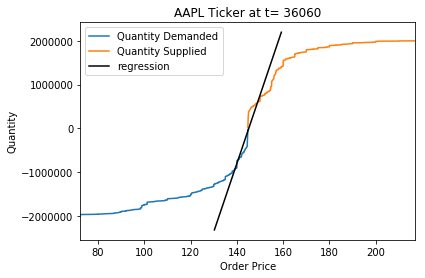

Estimated p_0 is 145.1134949060383
Midpoint of orderbook 144.73


In [383]:
Orderbook_graphic(outs[0], 30, 'AAPL')

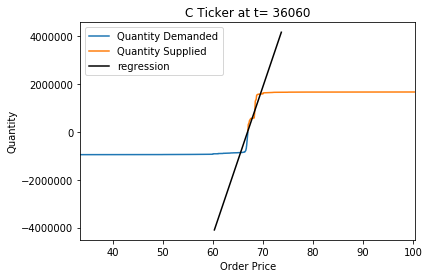

Estimated p_0 is 66.92357838181752
Midpoint of orderbook 66.98


In [384]:
Orderbook_graphic(outs[1], 30, 'C')

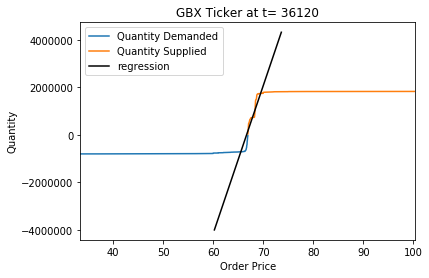

Estimated p_0 is 66.67039455143393
Midpoint of orderbook 66.93


In [390]:
Orderbook_graphic(outs[1], 31, 'GBX')

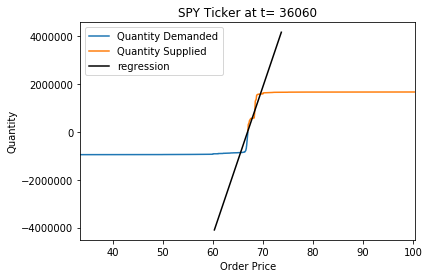

Estimated p_0 is 66.92357838181752
Midpoint of orderbook 66.98


In [386]:
Orderbook_graphic(outs[1], 30, 'SPY')

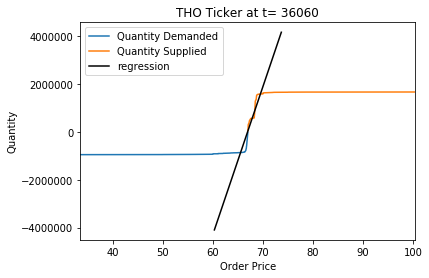

Estimated p_0 is 66.92357838181752
Midpoint of orderbook 66.98


In [387]:
Orderbook_graphic(outs[1], 30, 'THO')

Its clear that the estimate fits best very close to the midpoint of the orderbook, i.e. the BBO.

## Exercise 2:

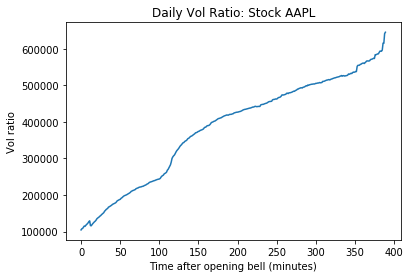

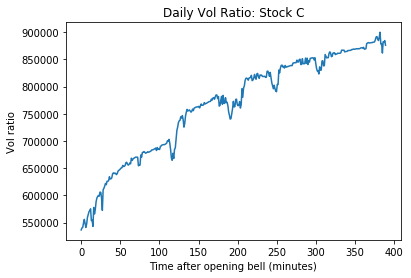

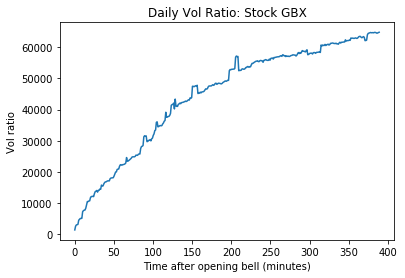

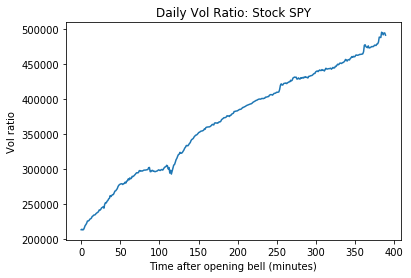

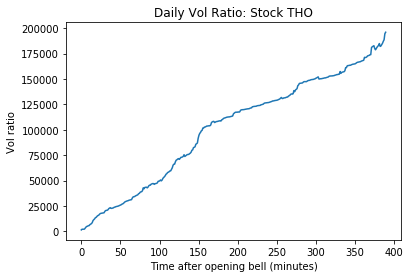

In [393]:
icount = 0
for file in outs:
    
    fname = file_list[icount]
    beta_hats = np.zeros(389)
    for i in range(389):
        book = Orderbook(file[i])
        book.regress()
        beta_hats[i]= book.beta
    plt.plot(np.linspace(0,389,389), beta_hats)
    plt.title('Daily Vol Ratio: Stock {}'.format(fname))
    plt.xlabel('Time after opening bell (minutes)')
    plt.ylabel('Vol ratio')
    plt.show()
    icount +=1 

## Exercise 3:

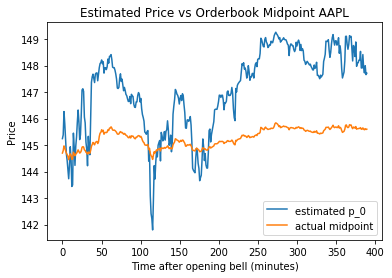

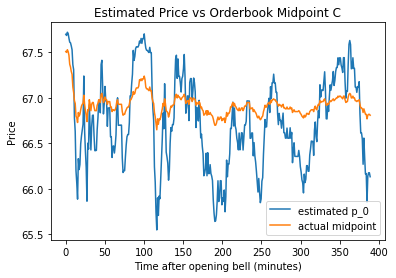

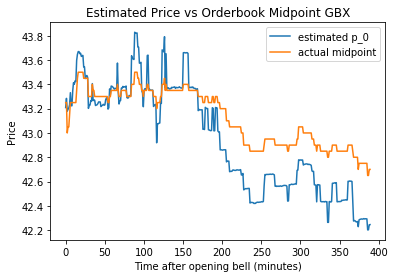

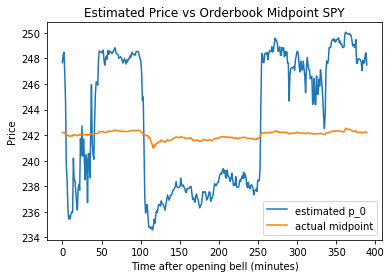

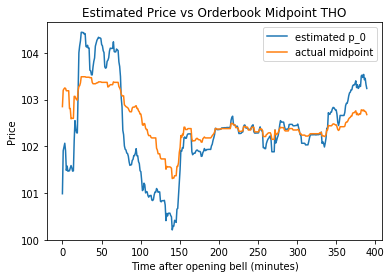

In [398]:
icount = 0
for file in outs:
    
    fname = file_list[icount]
    p_hats = np.zeros(389)
    midpoints = np.zeros(389)
    for i in range(389):
        book = Orderbook(file[i])
        book.regress()
        p_hats[i]= book.p
        midpoints[i] = book.midpoint
    plt.plot(np.linspace(0,389,389), p_hats, label='estimated p_0')
    plt.plot(np.linspace(0,389,389), midpoints, label='actual midpoint')
    plt.title('Estimated Price vs Orderbook Midpoint {}'.format(fname))
    plt.xlabel('Time after opening bell (minutes)')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    icount +=1 

We see that our estimate is very finicky and sensitive changing dramatically given a small change in the order book. It seems to capture the general trend but is inaccurate at any particular time point.

## Exercise 4:

The fact that all of the noise/signal ratios are increasing throughout the day is consisent with the behavior of traders that often wait to engage in volume trading until later in the day. 

Moreover, in tickers like SPY which is so heavily traded, we see that our estimates of p0 are quite bad due to more noise being present. If we look at something like THO, a recreational vehicle company with a (relatively) small market cap and lower volume of trading, our estimates of p_0 are much closer to the true BBO. 